In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, max_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

### Functions used

Below we have defined two functions. The first, test_model, is used to test different models with different data, returning the score, RVE and rmse values, which will then be used in the other function, test_data_set, which, on the one hand, allows us to build a database that uses the variations of n previous years to predict the variation of the next one (we can return only the dataset if the parameter set_model=True). On the other hand, it also allows you to test a range of years to obtain different databases. At the end, it displays a graph of the model scores for the different databases considered. The other function, validation_model, is used to test the two selected models (RandomForest and LinearRegression), considering the same set and the same division into training set and test set.

In [2]:
def test_model(set_population,year,model,labels,rve_list,rmse_list):
    X = set_population[labels].values
    y = set_population["Year"].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    rve = explained_variance_score(y_test,preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    rve_list.append(rve)
    rmse_list.append(rmse)
    return rve_list, rmse_list

def test_data_set(min_years,max_years,file,model=None, set_model=False):
    rve_list = []
    rmse_list = []
    years_list = []
    for year in range(min_years,max_years+1):
        set_values = pd.read_csv(file)
        years = list(set_values.columns[4:])
        set_values = set_values.dropna(how='all', subset=years)
        country_names = list(set_values["Country Name"].values)
        set_population = pd.DataFrame()
        for country in country_names:
            d = set_values[set_values["Country Name"]==country]
            for i in range(year,len(years)-1):
                dict_data = {"Country Name": country,"year":years[i]}
                for j in range(year,0,-1):
                    s = "Year - " + str(j)
                    dict_data[s] = d[years[i-j+1]].values - d[years[i-j]].values
                dict_data["Year"] = d[years[i+1]].values - d[years[i]].values
                df = pd.DataFrame(dict_data)
                set_population = pd.concat([set_population,df])
        set_population = set_population.dropna()
        labels = ["Year - " + str(j) for j in range(year,0,-1)]
        if set_model:
            return set_population
            break
        else:
            rve_list, rmse_list = test_model(set_population,year,model,labels,rve_list, rmse_list)
        years_list.append(year)
    print("RVE:", rve_list)
    print("rmse:", rmse_list)
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title("RVE vs years considered for prediction")
    plt.xlabel("Years")
    plt.ylabel("RVE")
    plt.plot(years_list,rve_list)
    plt.subplot(1, 2, 2)
    plt.title("RMSE vs vs years considered for prediction")
    plt.xlabel("Years")
    plt.ylabel("RMSE")
    plt.plot(years_list,rmse_list) 

In [28]:
def validation_model(X_train,y_train,X_test,y_test):
    model = RandomForestRegressor(n_jobs=-1)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    print("RVE for RandomForest model:", explained_variance_score(y_test,preds))
    print("rmse for RandomForest model:",mean_squared_error(y_test, preds, squared=False))
    model = LinearRegression()
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    print("RVE for LinearRegression model:", explained_variance_score(y_test,preds))
    print("rmse for LinearRegression model:",mean_squared_error(y_test, preds, squared=False))

# Country population

We began by testing the RandomForestRegressor model, using the variations between the last 5 years and the last 10 years to obtain the forecast for the following year. We then did the same for the LinearRegression() model. We then checked which was the best strategy and the best model, defined our data set that was used to train our model, randomly selected a set of countries and, using a WorldBank dataset that included data for 2017, went on to predict the variations from 2016 to 2017 for each of the countries. We added up the values for 2016 with the variations we predicted, thus obtaining results for 2017. To compare, we calculated the relative error between the values predicted by our model and the actual data. This whole process was repeated for the three variables, population, fertility rate and life expectancy.

### Testing the best strategy and model

RVE: [0.9993350630956482, 0.9994565091251143, 0.9994026221086678, 0.9993271279387453, 0.9994440160098922, 0.9991515980130363]
rmse: [288166.77768521756, 273869.09041850024, 250152.33563745627, 298966.57507481927, 267013.34046276344, 297260.94241283496]


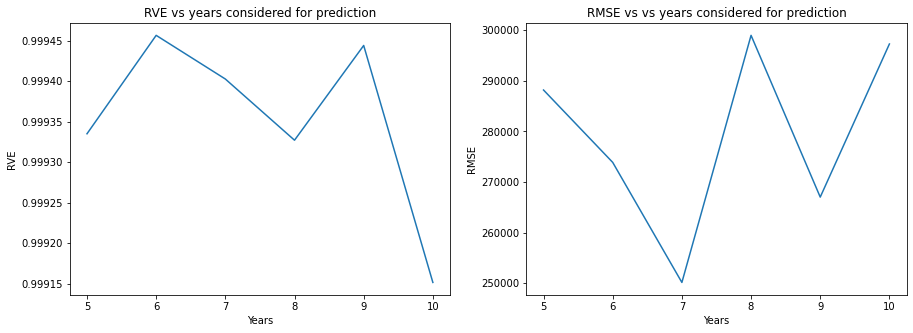

In [3]:
test_data_set(5,10,"country_population.csv",RandomForestRegressor(n_jobs=-1))

In [29]:
set_population = test_data_set(5,5,"country_population.csv",set_model=True)
X = set_population[["Year - " + str(j) for j in range(5,0,-1)]].values
y = set_population["Year"].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
validation_model(X_train,y_train,X_test,y_test)

RVE for RandomForest model: 0.999356618627987
rmse for RandomForest model: 282103.3021266689
RVE for LinearRegression model: 0.9995317077024198
rmse for LinearRegression model: 240670.25644047093


### Selection of 10 countries 

In [6]:
country = list(np.unique(set_population["Country Name"].values))
selected_countrys = random.sample(country, 10)
selected_countrys

['Europe & Central Asia (IDA & IBRD countries)',
 'Morocco',
 'Italy',
 'Dominica',
 'South Sudan',
 'Fragile and conflict affected situations',
 'Iraq',
 'San Marino',
 'Uganda',
 'Moldova']

### Training our model and forecast for 2017

In [7]:
population_test = pd.read_csv("country_population_test.csv")

In [8]:
data = []
for i in range(len(selected_countrys)):
    d = population_test[population_test["Country Name"] == selected_countrys[i]][["2011","2012","2013","2014","2015","2016"]].values[0]
    l = []
    for j in range(5,0,-1):
        l.append(d[5-j+1] - d[5-j])
    data.append(l)
data = np.array(data)
X = set_population[["Year - " + str(j) for j in range(5,0,-1)]].values
y = set_population["Year"].values
model = LinearRegression()
model.fit(X,y)
preds = model.predict(data)
preds_population = [preds[i] + population_test[population_test["Country Name"] == selected_countrys[i]]["2016"].values[0] for i in range(len(selected_countrys))]

### Comparing our forecasts with actual data

In [9]:
population_2017 = [population_test[population_test["Country Name"] == selected_countrys[i]]["2017"].values[0] for i in range(len(selected_countrys))]
print("Predictions for the year 2017")
for i in range(len(selected_countrys)):
    print(selected_countrys[i] + " - " + str(preds_population[i]))
print("")
print("Real data from 2017")
for i in range(len(selected_countrys)):
    print(selected_countrys[i] + " - " + str(population_2017[i]))

Predictions for the year 2017
Europe & Central Asia (IDA & IBRD countries) - 458603559.3835682
Morocco - 35533984.81890757
Italy - 60386006.23287193
Dominica - 74465.00240152633
South Sudan - 10825903.153621182
Fragile and conflict affected situations - 915787282.0695777
Iraq - 39500955.45434616
San Marino - 38466.297311009715
Uganda - 40086098.767904766
Moldova - 2768972.235181273

Real data from 2017
Europe & Central Asia (IDA & IBRD countries) - 458170561.0
Morocco - 35528115.0
Italy - 60536709.0
Dominica - 70403.0
South Sudan - 10658226.0
Fragile and conflict affected situations - 916099469.0
Iraq - 39621162.0
San Marino - 34056.0
Uganda - 40127085.0
Moldova - 2755189.0


In [10]:
print("Relative errors between our predictions and real values:")
for i in range(len(population_2017)):
    erro = (abs(population_2017[i]-preds_population[i])/population_2017[i])*100
    print(selected_countrys[i] + " - " + str(erro))

Relative errors between our predictions and real values:
Europe & Central Asia (IDA & IBRD countries) - 0.09450593740094691
Morocco - 0.016521616493209303
Italy - 0.2489444332497042
Dominica - 5.769643909387858
South Sudan - 1.573218222443227
Fragile and conflict affected situations - 0.03407784208881646
Iraq - 0.30338975331880064
San Marino - 12.950133048536866
Uganda - 0.10214106530597498
Moldova - 0.500264598228033


# Life expectancy

### Testing the best strategy and model

RVE: [0.7756675693669253, 0.7646876681473667, 0.7954932537323041, 0.7824289534472217, 0.7246777420603687, 0.703267906205743]
rmse: [0.18401044836288658, 0.1791663648963832, 0.17953088337043321, 0.1838458714040791, 0.20063314735240187, 0.18572883392675094]


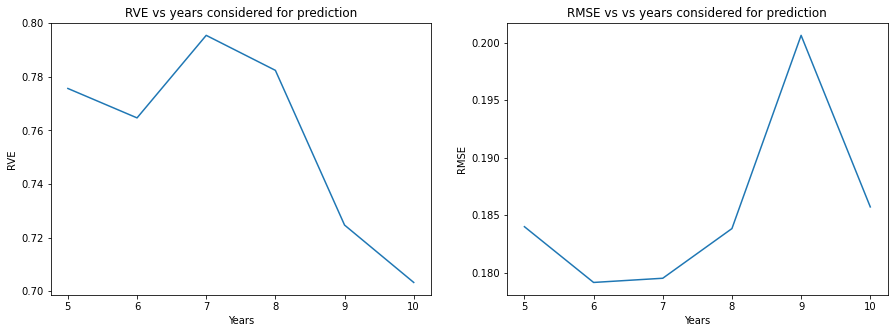

In [11]:
test_data_set(5,10,"life_expectancy.csv",RandomForestRegressor(n_jobs=-1))

In [30]:
set_life_expectancy = test_data_set(5,5,"life_expectancy.csv", set_model=True)
X = set_life_expectancy[["Year - " + str(j) for j in range(5,0,-1)]].values
y = set_life_expectancy["Year"].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
validation_model(X_train,y_train,X_test,y_test)

RVE for RandomForest model: 0.7764620369997292
rmse for RandomForest model: 0.18132387674751108
RVE for LinearRegression model: 0.7169667003434697
rmse for LinearRegression model: 0.20411034572839556


### Selection of 10 countries

In [13]:
country=list(np.unique(set_life_expectancy["Country Name"].values))
selected_countrys = random.sample(country, 10)
selected_countrys

['Seychelles',
 'China',
 'Germany',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Post-demographic dividend',
 'Middle income',
 'Middle East & North Africa (IDA & IBRD countries)',
 'World',
 'New Caledonia',
 'Early-demographic dividend']

###  Training our model and forecast for 2017

In [14]:
life_expectancy_test = pd.read_csv("life_expectancy_test.csv")

In [15]:
data = []
for i in range(len(selected_countrys)):
    d = life_expectancy_test[life_expectancy_test["Country Name"] == selected_countrys[i]][["2011","2012","2013","2014","2015","2016"]].values[0]
    l = []
    for j in range(5,0,-1):
        l.append(d[5-j+1] - d[5-j])
    data.append(l)
data = np.array(data)
X = set_life_expectancy[["Year - " + str(j) for j in range(5,0,-1)]].values
y = set_life_expectancy["Year"].values
model = RandomForestRegressor(n_jobs=-1)
model.fit(X,y)
preds = model.predict(data)
preds_life_expectancy = [preds[i] + life_expectancy_test[life_expectancy_test["Country Name"] == selected_countrys[i]]["2016"].values[0] for i in range(len(selected_countrys))]

### Comparing our forecasts with actual data

In [16]:
life_expectancy_2017 = [life_expectancy_test[life_expectancy_test["Country Name"] == selected_countrys[i]]["2017"].values[0] for i in range(len(selected_countrys))]
print("Predictions for the year 2017")
for i in range(len(selected_countrys)):
    print(selected_countrys[i] + " - " + str(preds_life_expectancy[i]))
print("")
print("Real data from 2017")
for i in range(len(selected_countrys)):
    print(selected_countrys[i] + " - " + str(life_expectancy_2017[i]))

Predictions for the year 2017
Seychelles - 74.52495333351243
China - 77.44398691129796
Germany - 81.02980777742292
Sub-Saharan Africa (IDA & IBRD countries) - 60.58405790062464
Post-demographic dividend - 80.6406271251176
Middle income - 71.93999418366933
Middle East & North Africa (IDA & IBRD countries) - 72.3840019490873
World - 72.55759922364467
New Caledonia - 76.74008595729583
Early-demographic dividend - 70.52536295407872

Real data from 2017
Seychelles - 74.3
China - 77.248
Germany - 80.9926829268293
Sub-Saharan Africa (IDA & IBRD countries) - 60.4771348418398
Post-demographic dividend - 80.5850349461617
Middle income - 71.9225502277337
Middle East & North Africa (IDA & IBRD countries) - 72.7432285455686
World - 72.5430440656125
New Caledonia - 77.5390243902439
Early-demographic dividend - 70.5420565547556


In [17]:
print("Relative errors between our predictions and real values:")
for i in range(len(life_expectancy_2017)):
    erro = (abs(life_expectancy_2017[i]-preds_life_expectancy[i])/life_expectancy_2017[i])*100
    print(selected_countrys[i] + " - " + str(erro))

Relative errors between our predictions and real values:
Seychelles - 0.30276357134916715
China - 0.2537113081218289
Germany - 0.045837289557568016
Sub-Saharan Africa (IDA & IBRD countries) - 0.17679914742070643
Post-demographic dividend - 0.0689857353701538
Middle income - 0.02425380618512397
Middle East & North Africa (IDA & IBRD countries) - 0.4938282279515017
World - 0.020064167722272527
New Caledonia - 1.030369467801283
Early-demographic dividend - 0.023664749076219627


# Fertility rate

### Testing the best strategy and model

RVE: [0.6739701413841006, 0.6670097793939768, 0.6943040691427047, 0.6587279262075236, 0.6869193168000078, 0.6619477795210015]
rmse: [0.04023004071821819, 0.039565422894041434, 0.0382398086472769, 0.03977306752971357, 0.03868109522078709, 0.040131693882143306]


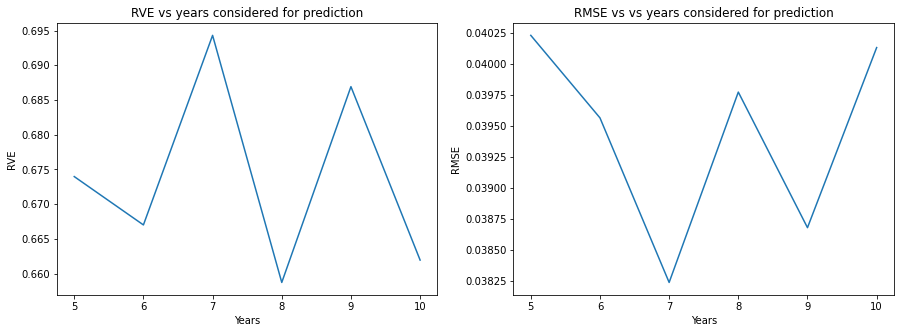

In [18]:
test_data_set(5,10,"fertility_rate.csv",RandomForestRegressor(n_jobs=-1))

In [34]:
set_fertility_rate = test_data_set(5,5,"fertility_rate.csv", set_model=True)
X = set_fertility_rate[["Year - " + str(j) for j in range(5,0,-1)]].values
y = set_fertility_rate["Year"].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
validation_model(X_train,y_train,X_test,y_test)

RVE for RandomForest model: 0.6478414277356055
rmse for RandomForest model: 0.043864159422416484
RVE for LinearRegression model: 0.595989727658247
rmse for LinearRegression model: 0.04698663246233513


### Selection of 10 countries

In [20]:
country=list(np.unique(set_fertility_rate["Country Name"].values))
selected_countrys = random.sample(country, 10)
selected_countrys

['Uganda',
 'Mongolia',
 'Sudan',
 'Afghanistan',
 'Guinea-Bissau',
 'Indonesia',
 'Bosnia and Herzegovina',
 'Timor-Leste',
 'IDA blend',
 'Brazil']

### Training our model and forecast for 2017

In [21]:
fertility_rate_test = pd.read_csv("fertility_rate_test.csv")

In [22]:
data = []
for i in range(len(selected_countrys)):
    d = fertility_rate_test[fertility_rate_test["Country Name"] == selected_countrys[i]][["2011","2012","2013","2014","2015","2016"]].values[0]
    l = []
    for j in range(5,0,-1):
        l.append(d[5-j+1] - d[5-j])
    data.append(l)
data = np.array(data)
X = set_fertility_rate[["Year - " + str(j) for j in range(5,0,-1)]].values
y = set_fertility_rate["Year"].values
model = RandomForestRegressor(n_jobs=-1)
model.fit(X,y)
preds = model.predict(data)
preds_fertility_rate = [preds[i] + fertility_rate_test[fertility_rate_test["Country Name"] == selected_countrys[i]]["2016"].values[0] for i in range(len(selected_countrys))]

### Comparing our forecasts with actual data

In [23]:
fertility_rate_2017 = [fertility_rate_test[fertility_rate_test["Country Name"] == selected_countrys[i]]["2017"].values[0] for i in range(len(selected_countrys))]
print("Predictions for the year 2017")
for i in range(len(selected_countrys)):
    print(selected_countrys[i] + " - " + str(preds_fertility_rate[i]))
print("")
print("Real data from 2017")
for i in range(len(selected_countrys)):
    print(selected_countrys[i] + " - " + str(fertility_rate_2017[i]))

Predictions for the year 2017
Uganda - 5.0650353731300175
Mongolia - 2.8965788838315776
Sudan - 4.801106817539682
Afghanistan - 5.132153001623847
Guinea-Bissau - 4.396831083749152
Indonesia - 2.2881358073758205
Bosnia and Herzegovina - 1.325034141273944
Timor-Leste - 3.5875574669328056
IDA blend - 4.302713575016266
Brazil - 1.6511665668820954

Real data from 2017
Uganda - 5.052
Mongolia - 2.891
Sudan - 4.761
Afghanistan - 5.129
Guinea-Bissau - 4.358
Indonesia - 2.262
Bosnia and Herzegovina - 1.355
Timor-Leste - 3.596
IDA blend - 4.28734363697537
Brazil - 1.736


In [24]:
print("Relative errors between our predictions and real values:")
for i in range(len(fertility_rate_2017)):
    erro = (abs(fertility_rate_2017[i]-preds_fertility_rate[i])/fertility_rate_2017[i])*100
    print(selected_countrys[i] + " - " + str(erro))

Relative errors between our predictions and real values:
Uganda - 0.25802401286654597
Mongolia - 0.19297418995425678
Sudan - 0.8424032249460601
Afghanistan - 0.06147400319452171
Guinea-Bissau - 0.8910299162265388
Indonesia - 1.1554291501246878
Bosnia and Herzegovina - 2.2115024890078274
Timor-Leste - 0.23477566927681998
IDA blend - 0.35849559406298076
Brazil - 4.886718497575149
